In [1]:
# 04_lr_on_embeddings.ipynb
"""
Logistic regression on neural network embeddings

This notebook loads the hidden layer embeddings from the feed forward neural network
(trained in 03_model_nn.ipynb) and trains a logistic regression classifier on top
of those embeddings. We then evaluate performance on validation and test sets and
compare to the baseline logistic regression on raw features.
"""

import os
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "../data_processed"

emb_train = np.load(os.path.join(DATA_DIR, "embeddings_train.npy"))
emb_val   = np.load(os.path.join(DATA_DIR, "embeddings_val.npy"))
emb_test  = np.load(os.path.join(DATA_DIR, "embeddings_test.npy"))

y_train = np.load(os.path.join(DATA_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(DATA_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(DATA_DIR, "y_test.npy"))

print("Embedding shapes:")
print("  train:", emb_train.shape)
print("  val:  ", emb_val.shape)
print("  test: ", emb_test.shape)

print("\nPositive class rates:")
print("  train:", y_train.mean())
print("  val:  ", y_val.mean())
print("  test: ", y_test.mean())

Embedding shapes:
  train: (71234, 32)
  val:   (15264, 32)
  test:  (15265, 32)

Positive class rates:
  train: 0.11160401
  val:   0.11156971
  test:  0.11162791


In [3]:
def eval_lr(model, X, y, set_name="val"):
    """
    Evaluate a binary classifier with predict_proba on a dataset.
    Returns a metrics dict plus predictions and probabilities.
    """
    probs = model.predict_proba(X)[:, 1]
    preds = (probs >= 0.5).astype(int)

    metrics = {
        "set": set_name,
        "AUROC": roc_auc_score(y, probs),
        "AUPRC": average_precision_score(y, probs),
        "Accuracy": accuracy_score(y, preds),
    }
    return metrics, preds, probs

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
emb_train_scaled = scaler.fit_transform(emb_train)
emb_val_scaled = scaler.transform(emb_val)
emb_test_scaled = scaler.transform(emb_test)

lr_emb = LogisticRegression(
    penalty="l2",
    C=0.5,
    solver="lbfgs",
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1,
)

lr_emb.fit(emb_train_scaled, y_train)

metrics_val, preds_val, probs_val = eval_lr(lr_emb, emb_val_scaled, y_val, "val")
metrics_test, preds_test, probs_test = eval_lr(lr_emb, emb_test_scaled, y_test, "test")

In [5]:
lr_emb.fit(emb_train, y_train)

print("Trained logistic regression on embeddings.")

Trained logistic regression on embeddings.


In [6]:
metrics_val, preds_val, probs_val = eval_lr(lr_emb, emb_val, y_val, "val")
metrics_test, preds_test, probs_test = eval_lr(lr_emb, emb_test, y_test, "test")

print("Validation metrics (LR on embeddings):")
print(metrics_val)

print("\nTest metrics (LR on embeddings):")
print(metrics_test)

Validation metrics (LR on embeddings):
{'set': 'val', 'AUROC': np.float64(0.6049272457289723), 'AUPRC': np.float64(0.17004751054217015), 'Accuracy': 0.6688286163522013}

Test metrics (LR on embeddings):
{'set': 'test', 'AUROC': np.float64(0.6131624258739765), 'AUPRC': np.float64(0.1771986727779656), 'Accuracy': 0.6706190632165083}


In [7]:
results_val = pd.DataFrame([{"model": "LR_on_embeddings", **metrics_val}]).set_index("model")
results_test = pd.DataFrame([{"model": "LR_on_embeddings", **metrics_test}]).set_index("model")

print("Validation:")
display(results_val)

print("\nTest:")
display(results_test)

Validation:


,set,AUROC,AUPRC,Accuracy
model,,,,
LR_on_embeddings,val,0.604927,0.170048,0.668829



Test:


,set,AUROC,AUPRC,Accuracy
model,,,,
LR_on_embeddings,test,0.613162,0.177199,0.670619


Confusion matrix (test, LR on embeddings):
[[9443 4118]
 [ 910  794]]


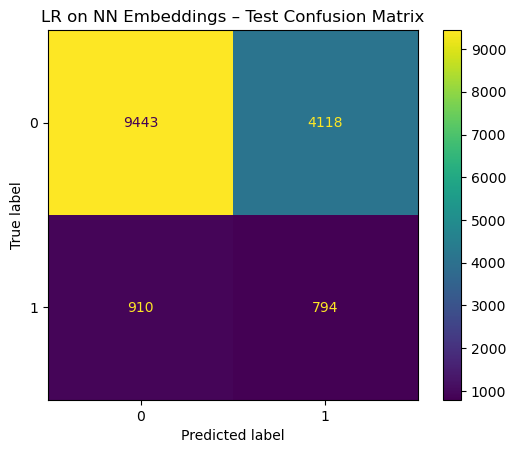


Classification report (test, LR on embeddings):
              precision    recall  f1-score   support

         0.0      0.912     0.696     0.790     13561
         1.0      0.162     0.466     0.240      1704

    accuracy                          0.671     15265
   macro avg      0.537     0.581     0.515     15265
weighted avg      0.828     0.671     0.728     15265



In [8]:
cm = confusion_matrix(y_test, preds_test)
print("Confusion matrix (test, LR on embeddings):")
print(cm)

disp = RocCurveDisplay

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(values_format="d")
plt.title("LR on NN Embeddings – Test Confusion Matrix")
plt.show()

print("\nClassification report (test, LR on embeddings):")
print(classification_report(y_test, preds_test, digits=3))

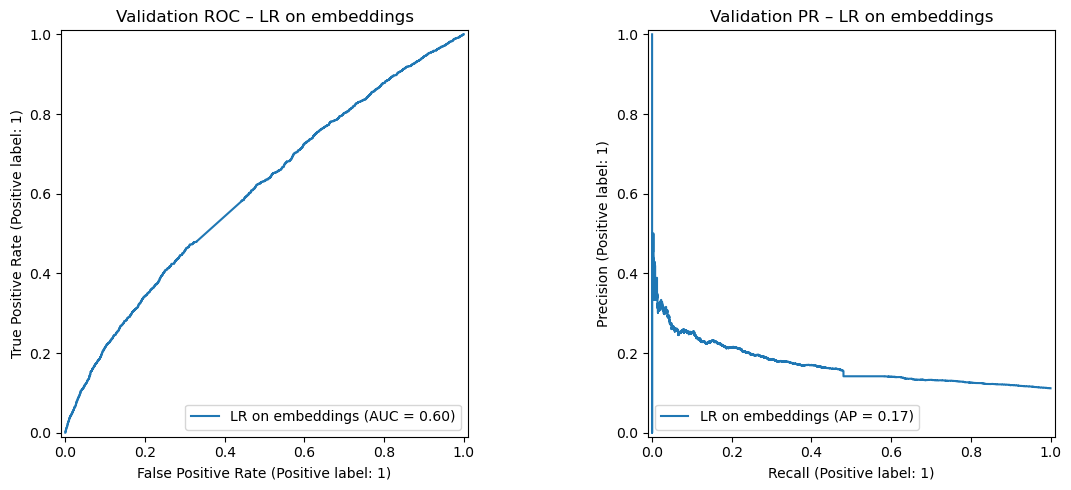

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

RocCurveDisplay.from_predictions(y_val, probs_val, ax=axes[0], name="LR on embeddings")
axes[0].set_title("Validation ROC – LR on embeddings")

PrecisionRecallDisplay.from_predictions(y_val, probs_val, ax=axes[1], name="LR on embeddings")
axes[1].set_title("Validation PR – LR on embeddings")

plt.tight_layout()
plt.show()